In [1]:
import torch
import os
import nrrd
import matplotlib.pyplot as plt
import pathlib
from torch.utils.data import Dataset, DataLoader
import numpy as np
import SimpleITK as sitk
from einops import  rearrange


def get_patient_files(path_to_imgs):

    path_to_imgs = pathlib.Path(path_to_imgs)

    patients = [p for p in os.listdir(path_to_imgs) if os.path.isdir(path_to_imgs / p)]

    paths = []

    for p in patients:
        path_to_ct = path_to_imgs / p / (p + '_ct.nrrd')
        path_to_gt = path_to_imgs / p / (p + '_gt.seg.nrrd')

        paths.append((path_to_ct, path_to_gt))
    return paths

class SegaDataset(Dataset):
    
    def __init__(self, paths_to_samples, transforms=None):
        self.transforms = transforms
        self.paths = get_patient_files(paths_to_samples)


    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
       
        sample = dict()

        id_ = self.paths[index][0].parent.stem

        sample['id']  = id_
        img_data, header = nrrd.read(self.paths[index][0])
        img_data = np.int16(img_data)
        img_data = rearrange(img_data, 'h w d -> d w h')
        # img_data = sitk.GetArrayFromImage(img)
        img_data = np.expand_dims(img_data, axis=3)
        sample['input'] = img_data

        mask_data, header = nrrd.read(self.paths[index][-1])
        mask_data = np.int16(mask_data)
        # print(mask_data.dtype)
        mask_data = rearrange(mask_data, 'h w d -> d w h')
        # mask_data = sitk.GetArrayFromImage(mask)
        mask_data = np.expand_dims(mask_data, axis=3)

        sample['target'] = mask_data

        if self.transforms:
            sample = self.transforms(sample)
        
        return sample


    @staticmethod
    def read_nrrd_file(path):
        img = sitk.ReadImage(str(path), sitk.sitkFloat32)

        return img
        
    @staticmethod
    def load_nrrd(full_path_filename,dtype=sitk.sitkFloat32):
        '''
        N*h*W
        :param full_path_filename:
        :return:*H*W
        '''
        if not os.path.exists(full_path_filename):
            raise FileNotFoundError
        image = sitk.ReadImage(full_path_filename)
        image = sitk.Cast(sitk.RescaleIntensity(image), dtype)
        # data = sitk.GetArrayFromImage(image) # N*H*W
        return image

In [2]:
import os
import sys
import pathlib

import numpy as np
import pandas as pd
import SimpleITK as sitk
from tqdm.notebook import tqdm
import torch
import matplotlib.pyplot as plt
%matplotlib inline
import nrrd
from einops import  rearrange
from monai.networks.nets import UNETR, SwinUNETR, SegResNet

# from src.models.components.models import BaselineUNet, FastSmoothSENormDeepUNet_supervision_skip_no_drop
# from src.models.sega_module import SegaModule
# from src.data.components.sega_dataset import SegaDataset
# from src.models.components.metrics import dice
from torch.utils.data import ConcatDataset, DataLoader, Dataset, random_split, Subset
from sklearn.model_selection import KFold


Failed to load image Python extension: dlopen(/opt/anaconda3/envs/sega/lib/python3.9/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <CAE66874-17C2-35C9-9C4D-6BA9770AF17F> /opt/anaconda3/envs/sega/lib/python3.9/site-packages/torchvision/image.so
  Expected in:     <DAEF2BE1-BBB4-3005-8003-63A504CDB9D9> /opt/anaconda3/envs/sega/lib/python3.9/site-packages/torch/lib/libtorch_cpu.dylib


In [3]:
def dice(input, target):
    axes = tuple(range(1, input.dim()))
    bin_input = (input > 0.5).float()

    intersect = (bin_input * target).sum(dim=axes)
    union = bin_input.sum(dim=axes) + target.sum(dim=axes)
    score = 2 * intersect / (union + 1e-5)

    return score.mean()

In [14]:
data_path = pathlib.Path('/Users/ikboljon.sobirov/Documents/sega23/segaorta_resampled/')

chkpt_paths = ['/Users/ikboljon.sobirov/Documents/sega23/epoch_047.ckpt',
                '/Users/ikboljon.sobirov/Documents/sega23/epoch_062.ckpt',
                # '/Users/ikboljon.sobirov/Documents/sega23/epoch_097.ckpt',
                ]

output_path = pathlib.Path('/Users/ikboljon.sobirov/Documents/sega23/segaorta_resampled_pred/')

if not os.path.exists(output_path):
            os.makedirs(output_path, exist_ok=True)


In [15]:
from torch.utils.data import DataLoader
from augmentations import *

trans_pred = Compose([
                    NormalizeIntensity(),
                    ToTensor(), 
                    Resizing(z=256,x=256,y=256),
                    ])

trans_orig = Compose([
                    NormalizeIntensity(),
                    ToTensor(), 
                    ]) 

dataset_pred = SegaDataset(data_path, transforms=trans_pred)
dataset_orig = SegaDataset(data_path, transforms=trans_orig)


full_indices = range(len(dataset_pred))

kf = KFold(n_splits=5, shuffle=True, random_state=786)

train_idx = {}
test_idx = {}

key = 1
for i,j in kf.split(full_indices):
    train_idx[key] = i
    test_idx[key] = j

    key += 1

_, val_dataset_pred = Subset(dataset_pred, train_idx[1]), Subset(dataset_pred, test_idx[1])
_, val_dataset_orig = Subset(dataset_orig, train_idx[1]), Subset(dataset_orig, test_idx[1])

print(len(dataset_pred), len(val_dataset_orig), len(val_dataset_pred))



pred_loader = DataLoader(
            dataset=val_dataset_pred,
            batch_size=1,
            # num_workers=8,
            pin_memory=True,
            shuffle=False,
            drop_last=True,
        )

orig_loader = DataLoader(
            dataset=val_dataset_orig,
            batch_size=1,
            # num_workers=8,
            pin_memory=True,
            shuffle=False,
            drop_last=True,
        )


56 12 12


In [16]:
data_pred = next(iter(pred_loader))

In [17]:
data_orig = next(iter(orig_loader))

In [18]:
print(data_pred['id'])
print(data_orig['id'])

['D9']
['D9']


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [32]:
def load_model_weights(model, path_to_model_weights):
    model_state_dict = torch.load(path_to_model_weights, map_location=lambda storage, loc: storage)
    state_dict = model_state_dict['state_dict']
    
    for key in list(state_dict):
        state_dict[key.replace("model.", "")] = state_dict.pop(key)

    model.load_state_dict(state_dict)
    return model


In [33]:
model = SegResNet(in_channels=1, out_channels=1)

# if device.type == 'cpu':
#     checkpoint = torch.load(chkpt_path, map_location=torch.device('cpu'))
# else:
#     checkpoint = torch.load(chkpt_path)

if device.type == 'cpu':
    print(f'Run inference for an ensemble of {len(chkpt_paths)} models on CPU')
else:
    print(f'Run inference for an ensemble of {len(chkpt_paths)} models'
            f' on {torch.cuda.get_device_name(torch.cuda.current_device())}')

model = model.to(device)
model.eval()


Run inference for an ensemble of 2 models on CPU


SegResNet(
  (act_mod): ReLU(inplace=True)
  (convInit): Convolution(
    (conv): Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
  )
  (down_layers): ModuleList(
    (0): Sequential(
      (0): Identity()
      (1): ResBlock(
        (norm1): GroupNorm(8, 8, eps=1e-05, affine=True)
        (norm2): GroupNorm(8, 8, eps=1e-05, affine=True)
        (act): ReLU(inplace=True)
        (conv1): Convolution(
          (conv): Conv3d(8, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        )
        (conv2): Convolution(
          (conv): Conv3d(8, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        )
      )
    )
    (1): Sequential(
      (0): Convolution(
        (conv): Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1), bias=False)
      )
      (1): ResBlock(
        (norm1): GroupNorm(8, 16, eps=1e-05, affine=True)
        (norm2): GroupNorm(8, 16, eps=1e-05, affine=Tr

In [34]:
metric_dictionary = {}
metric_dictionary['id'] = []
metric_dictionary['resize_metric'] = []
metric_dictionary['orig_metric'] = []


In [36]:
with torch.no_grad():
    for sample, orig in zip(pred_loader, orig_loader):
        print("Processing:", sample['id'])

        input = sample['input']

        ensemble_output = 0
        for path in chkpt_paths:
            model = load_model_weights(model, path)
            output = model(input)
            output = output.cpu()

            ensemble_output += output

        ensemble_output /= len(chkpt_paths)

        # output = model(input)

        # y_pred = output.float()
        y_pred = torch.where(ensemble_output>0.5, 1, 0).float()
        # Upsample back to original size
        y_pred = y_pred.squeeze(0)
        y_orig = tio.Resize(orig['input'].squeeze().shape, image_interpolation='nearest')(y_pred)
        # Save prediction:

        
        metric_value_rs = dice(y_pred.unsqueeze(0).detach(), sample['target'].detach())
        metric_value_or = dice(y_orig.unsqueeze(0).detach(), orig['target'].detach())

        metric_dictionary['id'].append(sample['id'][0])
        metric_dictionary['resize_metric'].append(metric_value_rs.item())
        metric_dictionary['orig_metric'].append(metric_value_or.item())
        
        print(f"id: {sample['id'][0]}, metric_rs: {metric_value_rs}, metric_org: {metric_value_or}")

        if not os.path.exists(output_path / sample['id'][0]):
            os.makedirs(output_path / sample['id'][0], exist_ok=True)

        # write_nifti(sitk.GetImageFromArray(y_pred.squeeze()),  str(output_path / sample['id'][0] / (sample['id'][0] +'_resize.nrrd')))
        # write_nifti(sitk.GetImageFromArray(y_orig.squeeze()),  str(output_path / sample['id'][0] / (sample['id'][0] +'.nrrd')))
        sitk.WriteImage(sitk.GetImageFromArray(y_orig.squeeze()),  str(output_path / sample['id'][0] / (sample['id'][0] +'_pr.seg.nrrd')), useCompression=True)
        # break


Processing: ['D9']
id: D9, metric_rs: 0.9270153045654297, metric_org: 0.9248929619789124
Processing: ['K5']
id: K5, metric_rs: 0.8301315307617188, metric_org: 0.8283371925354004
Processing: ['R7']
id: R7, metric_rs: 0.8323187828063965, metric_org: 0.8276515603065491
Processing: ['R6']
id: R6, metric_rs: 0.8188565969467163, metric_org: 0.817129373550415
Processing: ['K7']


In [54]:
print("Resize:", np.mean(sorted(metric_dictionary['resize_metric'])))
print("Original Mean:", np.mean(sorted(metric_dictionary['orig_metric'])[1:]))
print("Original SD:", np.std(sorted(metric_dictionary['orig_metric'])))

Resize: 0.8293382028738657
Original Mean: 0.8323791027069092
Original SD: 0.04566924787160509


In [55]:
(sorted(metric_dictionary['orig_metric']))

[0.7565342783927917,
 0.7642958760261536,
 0.788438081741333,
 0.8144479990005493,
 0.8147838115692139,
 0.8229645490646362,
 0.8254221081733704,
 0.8269250392913818,
 0.8315982222557068,
 0.8474909663200378,
 0.9014589786529541,
 0.9183444976806641]

In [57]:
new = pd.DataFrame.from_dict(metric_dictionary)

In [58]:
new

,id,resize_metric,orig_metric
0,D9,0.918307,0.918344
1,K5,0.791912,0.788438
2,R7,0.819081,0.814784
3,R6,0.765825,0.764296
4,K7,0.819451,0.814448
5,D4,0.911339,0.901459
6,R10,0.823756,0.822965
7,K1,0.849784,0.847491
8,K6,0.834172,0.831598
9,R18,0.757631,0.756534


In [59]:
new.to_csv('metrics')

### Resample back to the original size/spacing/etc

In [129]:
original_path = '/Users/ikboljon.sobirov/Documents/sega23/SegAorta/'
predicted_path = '/Users/ikboljon.sobirov/Documents/sega23/segaorta_resampled_pred/'
out_path = '/Users/ikboljon.sobirov/Documents/sega23/segaorta_resampled_pred_resampled/'

In [4]:
patients = os.listdir(predicted_path)
len(patients)

13

In [6]:
patients.remove('.DS_Store')

In [156]:
def resample_sitk_image_new(reference_image,
                        original_img,
                        interpolator = sitk.sitkNearestNeighbor):
    

    fill_value = 0

    orig_pixelid = original_img.GetPixelIDValue()
    orig_origin = reference_image.GetOrigin()
    orig_direction = original_img.GetDirection()
    orig_spacing = np.array(original_img.GetSpacing())
    orig_size = original_img.GetSize()

    # new_size = original_img.GetSize() * (orig_spacing / orig_spacing)
    # new_size = np.ceil(new_size).astype(int)  # Image dimensions are in integers
    # new_size = [int(s) for s in new_size]
    
    resample_filter = sitk.ResampleImageFilter()
    resample_filter.SetSize(orig_size)
    resample_filter.SetTransform(sitk.Transform())
    resample_filter.SetInterpolator(interpolator)
    # resample_filter.SetOrigin(orig_origin)
    resample_filter.SetOutputSpacing(orig_spacing)
    resample_filter.SetOutputDirection(orig_direction)
    resample_filter.SetDefaultPixelValue(fill_value)
    resample_filter.SetOutputPixelType(orig_pixelid)

    resampled_sitk_image = resample_filter.Execute(reference_image)
    resampled_sitk_image.SetOrigin(original_img.GetOrigin())
    return resampled_sitk_image

In [160]:
for p in patients:
    p_path_pred = os.path.join(predicted_path, p, (p+'_pr.seg.nrrd'))
    p_path_orig = os.path.join(original_path, p, (p+'.seg.nrrd'))

    p_pred = sitk.ReadImage(p_path_pred)
    p_orig = sitk.ReadImage(p_path_orig)

    print("Before resampling:")
    print("Predicted:", p_pred.GetSize(), p_pred.GetSpacing(), p_pred.GetOrigin(), p_pred.GetDirection())
    print("Original", p_orig.GetSize(), p_orig.GetSpacing(), p_orig.GetOrigin(), p_orig.GetDirection())

    # p_pred_resampled = sitk.Resample(p_pred, p_orig, sitk.Transform(), sitk.sitkNearestNeighbor, 1, p_pred.GetPixelID())
    attributes = get_attributes(p_orig)
    p_pred_resampled = resample_sitk_image_new(p_pred, 
                                                p_orig,
                                                interpolator = sitk.sitkNearestNeighbor)
    
    # p_pred_resampled_fake = sitk.GetArrayFromImage(p_pred_resampled)
    # p_pred_resampled = sitk.GetImageFromArray(p_pred_resampled_fake)
    print("After resampling:")
    print("Resampled:", p_pred_resampled.GetSize(), p_pred_resampled.GetSpacing(), p_pred_resampled.GetOrigin(), p_pred_resampled.GetDirection())

    if not os.path.exists(os.path.join(out_path, p)):
        os.makedirs(os.path.join(out_path, p), exist_ok=True)

    sitk.WriteImage(p_pred_resampled, os.path.join(out_path, p, (p +'_pr.seg.nrrd')), useCompression=True)
    # break


Before resampling:
Predicted: (294, 383, 445) (1.0, 1.0, 1.0) (0.0, 0.0, 0.0) (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
Original (512, 666, 149) (0.57421875, 0.57421875, 2.9864851351351356) (-149.058, -20.514843750000004, -851.4998999999999) (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
After resampling:
Resampled: (512, 666, 149) (0.57421875, 0.57421875, 2.9864851351351356) (-149.058, -20.514843750000004, -851.4998999999999) (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
Before resampling:
Predicted: (448, 448, 755) (1.0, 1.0, 1.0) (0.0, 0.0, 0.0) (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
Original (512, 512, 302) (0.875, 0.875, 2.5) (-230.5625, -385.5625, -669.2) (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
After resampling:
Resampled: (512, 512, 302) (0.875, 0.875, 2.5) (-230.5625, -385.5625, -669.2) (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
Before resampling:
Predicted: (480, 480, 713) (1.0, 1.0, 1.0) (0.0, 0.0, 0.0) (1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
Original

In [158]:
np.unique(sitk.GetArrayFromImage(p_pred_resampled))

array([0, 1], dtype=uint8)

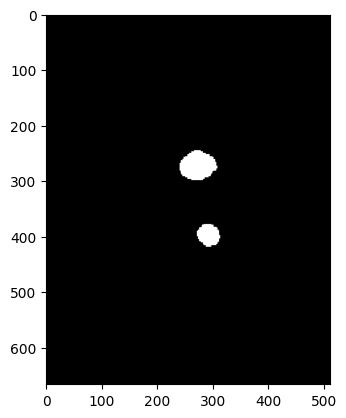

In [159]:
plt.imshow(sitk.GetArrayFromImage(p_pred_resampled[:,:,100]), cmap='gray')